# Intestinal organoid differentiation - Dynamo velocity for pulse experiment

Calculate RNA velocity using Dynamo and only pulse experiment

## Library imports

In [1]:
import sys

import numpy as np
from scipy.sparse import csr_matrix

import dynamo as dyn
import scanpy as sc
import scvelo as scv

from cr2 import prepare_data_for_dynamo, running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR  # isort: skip  # noqa: E402

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/vol/storage/miniconda3/envs/dynamo-py39/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo")

## Constants

In [4]:
N_JOBS = 8

## Data loading

In [5]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "preprocessed.h5ad")

adata.obs.rename({"labeling_time": "time"}, axis=1, inplace=True)
adata.layers["new"] = adata.layers.pop("labeled")

del adata.layers["unlabeled"]

adata

AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'total', 'new'
    obsp: 'connectivities', 'distances'

## Data preprocessing

In [6]:
# Setting entries needed by Dynamo
prepare_data_for_dynamo(adata, experiment_type="mix_pulse_chase")

adata.layers["X_total"] = csr_matrix(adata.layers["total"].copy())
adata.layers["X_new"] = csr_matrix(adata.layers["new"].copy())

In [7]:
ntr, var_ntr = dyn.preprocessing.utils.calc_new_to_total_ratio(adata)

adata.obs["ntr"] = ntr
adata.var["ntr"] = var_ntr

In [8]:
dyn.tl.moments(adata, conn=adata.obsp["connectivities"].copy(), group="time")
adata

|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [1.2946s]


AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts', 'pass_basic_filter', 'ntr'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'pass_basic_filter', 'use_for_pca', 'ntr'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap', 'pp', 'pca_fit', 'PCs', 'pca_mean'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'total', 'new', 'X_total', 'X_new', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn'
    obsp: 'connectivities', 'distances', 'moments_con'

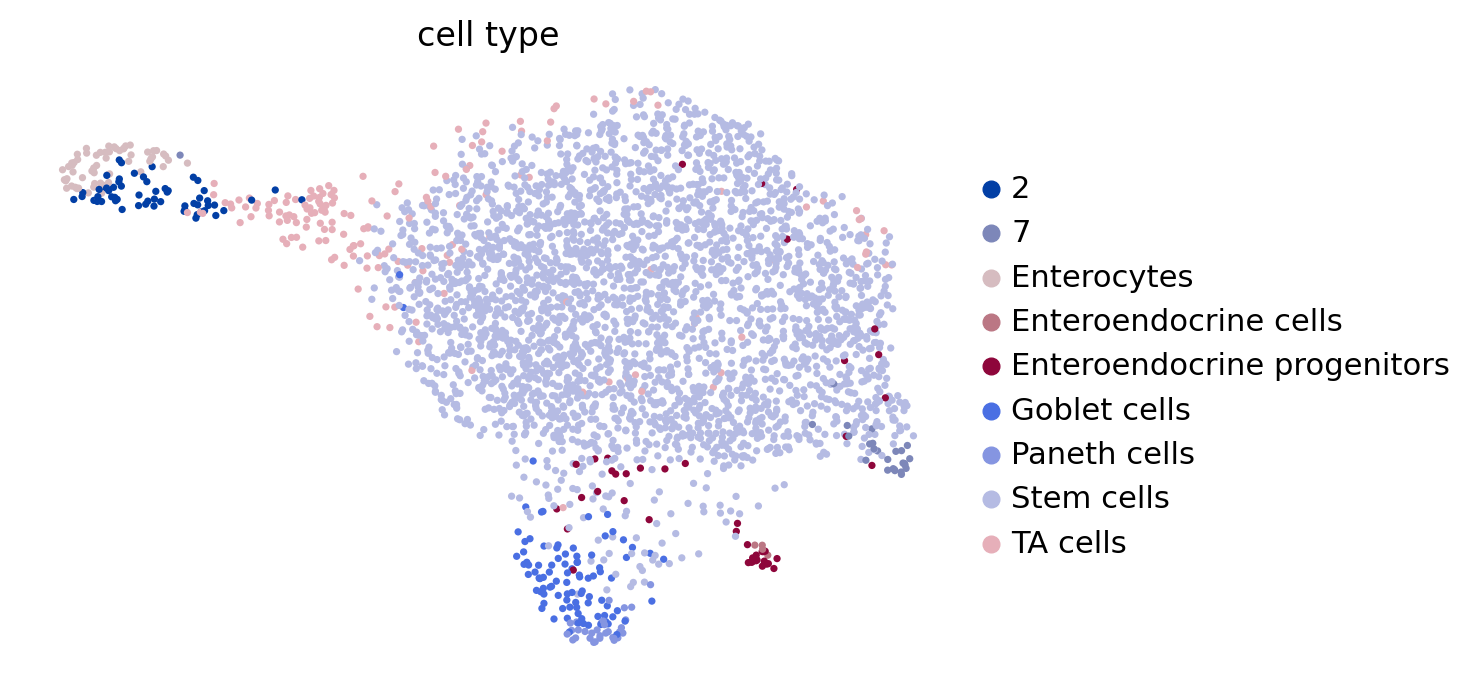

In [9]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color="cell_type", legend_loc="right")

## Parameter inference

In [10]:
dyn.tl.dynamics(adata, model="deterministic", tkey="time", assumption_mRNA="ss", cores=N_JOBS)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group None), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: mix_pulse_chase, method: direct, model: deterministic


estimating kinetic-parameters using kinetic model: 100%|██████████| 2000/2000 [00:11<00:00, 170.51it/s]


AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts', 'pass_basic_filter', 'ntr'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'pass_basic_filter', 'use_for_pca', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'use_for_dynamics'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap', 'pp', 'pca_fit', 'PCs', 'pca_mean', 'dynamics'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'total', 'new', 'X_total', 'X_new', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'velocity_N', 'velocity_T'
    obsp: 'connectivities', 'distances', 'moments_con'

In [11]:
adata = adata[:, ~adata.var["gamma"].isnull()]

adata.var["alpha"] = adata.var["alpha"].astype(float)
adata.var["beta"] = adata.var["beta"].replace({None: np.nan})
adata.var["gamma"] = adata.var["gamma"].replace({None: np.nan})
adata.var["half_life"] = adata.var["half_life"].replace({None: np.nan})
adata.var["a"] = adata.var["a"].astype(float)
adata.var["b"] = adata.var["b"].astype(float)
adata.var["alpha_a"] = adata.var["alpha_a"].astype(float)
adata.var["alpha_i"] = adata.var["alpha_i"].astype(float)
adata.var["p_half_life"] = adata.var["p_half_life"].astype(float)
adata.var["cost"] = adata.var["cost"].astype(float)
adata.var["logLL"] = adata.var["logLL"].astype(float)

del adata.uns["dynamics"]["X_fit_data"]

In [12]:
adata.write(DATA_DIR / "sceu_organoid" / "processed" / "adata_dynamo-chase_and_pulse-2000features.h5ad")